In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os
import pandas as pd
import configs
import torch

import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings('ignore', category=ConvergenceWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

from sklearn.decomposition import PCA
from scipy.spatial.distance import pdist, squareform
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import numpy as np

from src.utils import find_ckpt_file, convert_to_tensor
import h5py
import random
from src.evals.eval_trees import EvalTrees
from src.evals.eval_trees import EvalCntrees

# Arguments 

In [3]:
corr = 0.25
seq_length = 800

# Load Model

In [4]:
model_name, path_to_pkl, eval_dset_path = configs.get_model_paths(corr, "tree_maze")

epoch=35-val_loss=0.000347.ckpt


In [5]:
# Extract parameters using regex
import re

n_embd = int(re.search(r'embd(\d+)', model_name).group(1))
n_layer = int(re.search(r'layer(\d+)', model_name).group(1))
n_head = int(re.search(r'head(\d+)', model_name).group(1))
dropout = float(re.search(r'drop(\d*\.?\d*)', model_name).group(1))

# Extract correlation and state_dim from eval dataset path
state_dim = int(re.search(r'state_dim(\d+)', eval_dset_path).group(1))

model_config = {
    "n_embd": n_embd,
    "n_layer": n_layer,
    "n_head": n_head,
    "state_dim": 10,
    "action_dim": 4,
    "dropout": dropout,
    "test": True,
    "name": "transformer_end_query",
    "optimizer_config": None,
}

In [6]:
from src.models.transformer_end_query import Transformer
model_config['initialization_seed'] = 0
model = Transformer(**model_config)
checkpoint = torch.load(path_to_pkl)
model.load_state_dict(checkpoint['state_dict'])
model.eval()
model = model.to('cuda')


# Load Dataset and Create Environment

In [7]:
n_eval_envs = -1 #50

is_h5_file = eval_dset_path.endswith('.h5')
if is_h5_file:
    eval_trajs = h5py.File(eval_dset_path, 'r')
    traj_indices = list(eval_trajs.keys())
    n_eval_envs = min(n_eval_envs, len(traj_indices))
    random.seed(0)
    traj_indices = random.sample(traj_indices, n_eval_envs)
    random.seed()
    if n_eval_envs != -1:
        eval_trajs = [eval_trajs[i] for i in traj_indices]
    else:
        n_eval_envs = len(traj_indices)
else:  # Pickle file
    with open(eval_dset_path, 'rb') as f:
        eval_trajs = pickle.load(f)
    n_eval_envs = min(n_eval_envs, len(eval_trajs))
    if n_eval_envs != -1:
        random.seed(0)
        eval_trajs = random.sample(eval_trajs, n_eval_envs)
        random.seed()
    else:
        n_eval_envs = len(eval_trajs)


In [8]:
def run_model(traj, model, seq_length=1200, start_idx=800):
    hidden_states = []

    batch = {
        'context_states': convert_to_tensor([np.array(traj['context_states'])]),
        'context_actions': convert_to_tensor([np.array(traj['context_actions'])]),
        'context_next_states': convert_to_tensor([np.array(traj['context_next_states'])]),
        'context_rewards': convert_to_tensor([np.array(traj['context_rewards'])[:, None]]),
        'query_states': convert_to_tensor([np.array(traj['query_state'])]),  # Ignored
        }
    batch['zeros'] = torch.zeros(1, 10 ** 2 + 4 + 1).float()
    for k in batch.keys():
        if 'context' in k:
            batch[k] = batch[k][:,:seq_length]
        batch[k] = batch[k].to(model.device)
    model.save_activations = True
    with torch.no_grad():
        out = model(batch)
    _hidden_states = model.activations['hidden_states'] # Tuple over layers of (1, seq, dim)
    state_features = batch['context_states'][0][start_idx:].to('cpu').numpy()
    next_state_features = batch['context_next_states'][0][start_idx:].to('cpu').numpy()
    actions = batch['context_actions'][0].argmax(dim=1)[start_idx:].to('cpu').numpy()
    for i_layer in range(len(_hidden_states)):
        hidden_states.append(_hidden_states[i_layer][0,start_idx:-1])
    return hidden_states, state_features, next_state_features, actions

# Across context decoding
(within-context is not that good)

In [9]:
def get_subtree_location(layer, pos, subtree):
    midpt = 2**(layer-1)
    quarter_pt = midpt//2
    eighth_pt = quarter_pt//2
    if layer == 0:
        return 0
    if subtree == 'half':
        return 1 if pos < midpt else 2
    elif subtree == 'quarter':
        if layer == 1:
            return 0
        bins = np.arange(0, 2**layer, quarter_pt)
        return np.digitize([pos], bins)[0]
    elif subtree == 'eighth':
        if (layer == 1) or (layer == 2):
            return 0
        bins = np.arange(0, 2**layer, eighth_pt)
        return np.digitize([pos], bins)[0]

    

In [10]:
def make_train_test_matrices():
    X = [[] for _ in range(model.n_layer+1)]
    Ys_dict = {
        "dist_from_goal": [],
        "layer": [],
        "node_identity": [],
        "maze_half": [],
        "maze_quarter": [],
        "maze_eighth": [],
        'is_goal': [],
        'same_half_as_goal': [],
        'same_quarter_as_goal': [],
        'opt_action': [],
        'state_feature': [],
        'next_state_feature': [],
        "on_path": [],
        "on_lr_path": [],
        "inverse_action": [],
        "action": []
    }
    for i_eval in range(n_eval_envs):
        onehot_env = np.zeros(n_eval_envs)
        onehot_env[i_eval] = 1
        traj = eval_trajs[i_eval]
        first_reward = np.argwhere(np.array(traj['context_rewards'])>0)
        if (first_reward.size == 0) or (first_reward[0] > seq_length):
            continue
        start_idx = first_reward[0].item()

        env_config = {
            'max_layers': 7,
            'horizon': 1600,
            'branching_prob': 1.0,
            'node_encoding_corr': corr,
            'state_dim': state_dim,
            'initialization_seed': np.array(traj['initialization_seed']).item()
        }
        env = EvalCntrees().create_env(env_config, np.array(traj['goal']), i_eval)
        opt_action_map, dist_from_goal = env.make_opt_action_dict()
        s = env.root.encoding()
        states_on_path_from_root_to_goal = [s]
        while True:
            action = np.zeros(4)
            action[opt_action_map[tuple(s)]] = 1
            s, _ = env.transit(np.array(s), action)
            states_on_path_from_root_to_goal.append(tuple(s))
            if np.array_equal(s, env.goal):
                break

        hidden_states, state_features, next_state_features, actions = run_model(traj, model, seq_length, start_idx)
        goal_node = env.node_map[tuple(env.goal.tolist())]
        goal_layer = goal_node.layer
        goal_pos = goal_node.pos
        seen_combos = set()
        for state_idx in reversed(range(len(state_features))):
            state_feature = state_features[state_idx]
            next_state_feature = next_state_features[state_idx]
            state_feature_tuple = tuple(state_feature.tolist())
            next_state_feature_tuple = tuple(next_state_feature.tolist())
            action = actions[state_idx]
            combo = tuple(state_feature.tolist() + next_state_feature.tolist())
            if combo in seen_combos:
                continue
            seen_combos.add(combo)
            d = dist_from_goal[next_state_feature_tuple]
            layer = env.node_map[next_state_feature_tuple].layer
            pos = env.node_map[next_state_feature_tuple].pos
            node_identity = 2**layer + pos
            maze_half = get_subtree_location(layer, pos, 'half')
            maze_quarter = get_subtree_location(layer, pos, 'quarter')
            maze_eighth = get_subtree_location(layer, pos, 'eighth')
            if action == 0:
                if env.node_map[next_state_feature_tuple].left == env.node_map[state_feature_tuple]:
                    inverse_action = 1
                elif env.node_map[next_state_feature_tuple].right == env.node_map[state_feature_tuple]:
                    inverse_action = 2
                else:
                    inverse_action = -1
            elif action == 1 or action == 2:
                inverse_action = 0
            else:
                inverse_action = 3

            on_lr_path = (state_feature_tuple in states_on_path_from_root_to_goal) and (next_state_feature_tuple in states_on_path_from_root_to_goal)
            
            Ys_dict["dist_from_goal"].append(d)
            Ys_dict["layer"].append(layer)
            Ys_dict["node_identity"].append(node_identity)
            Ys_dict["maze_half"].append(maze_half)
            Ys_dict["maze_quarter"].append(maze_quarter)
            Ys_dict["maze_eighth"].append(maze_eighth)
            Ys_dict["is_goal"].append(state_feature_tuple == tuple(env.goal.tolist()))
            Ys_dict["same_half_as_goal"].append(maze_half == get_subtree_location(goal_layer, goal_pos, 'half'))
            Ys_dict["same_quarter_as_goal"].append(maze_quarter == get_subtree_location(goal_layer, goal_pos, 'quarter'))
            Ys_dict["opt_action"].append(opt_action_map[state_feature_tuple])
            Ys_dict["state_feature"].append(state_feature)
            Ys_dict["next_state_feature"].append(next_state_feature)
            Ys_dict["on_path"].append(action == opt_action_map[state_feature_tuple])
            Ys_dict["on_lr_path"].append(on_lr_path)
            Ys_dict["inverse_action"].append(inverse_action)
            Ys_dict["action"].append(action)
            
            for layer in range(len(hidden_states)):
                hidden_state = hidden_states[layer][state_idx].to('cpu').numpy()
                hidden_state = np.concatenate([hidden_state, onehot_env])
                X[layer].append(hidden_state)
        torch.cuda.empty_cache()

    test_size = 0.1
    test_start_idx = int(len(X[0])*(1-test_size))
    all_indices = np.arange(len(X[0]))
    np.random.shuffle(all_indices)
    train_indices = all_indices[:test_start_idx]
    test_indices = all_indices[test_start_idx:]

    X_train = [[] for _ in range(len(X))]
    X_test = [[] for _ in range(len(X))]
    Ys_dict_train_test = {key: {'Y_train': [], 'Y_test': []} for key in Ys_dict}
    # Use same indices for all layers to keep corresponding samples together
    for layer, layer_data in enumerate(X):
        X_train[layer] = [layer_data[i] for i in train_indices]
        X_test[layer] = [layer_data[i] for i in test_indices]
    for key in Ys_dict:
        Ys_dict_train_test[key]['Y_train'] = [Ys_dict[key][i] for i in train_indices]
        Ys_dict_train_test[key]['Y_test'] = [Ys_dict[key][i] for i in test_indices]
    return X_train, X_test, Ys_dict_train_test

In [11]:
import warnings

from sklearn.metrics import balanced_accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import numpy as np

def fit_and_evaluate_regression(X_train, Y_train, X_test, Y_test, print_scores=True):
    from joblib import Parallel, delayed
    from sklearn.model_selection import KFold
    from sklearn.linear_model import Ridge
    
    X_train_np = [np.array([_x for _x in x]) for x in X_train]
    X_test_np = [np.array([_x for _x in x]) for x in X_test]
    Y_train_np = np.array(Y_train)
    Y_test_np = np.array(Y_test)

    alphas = np.logspace(0, 4, 10)
    n_splits = 5
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    def evaluate_fold(X, y, train_idx, val_idx, alpha):
        # Train on this fold
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('ridge', Ridge(alpha=alpha))
        ])
        pipeline.fit(X[train_idx], y[train_idx])
        # Get validation score
        val_score = pipeline.score(X[val_idx], y[val_idx])
        return val_score

    pipelines = []
    test_scores = []
    
    for layer in range(len(X_train)-1):
        # Parallel CV for each alpha
        cv_scores = {alpha: [] for alpha in alphas}
        for alpha in alphas:
            scores = Parallel(n_jobs=-1)(
                delayed(evaluate_fold)(
                    X_train_np[layer], Y_train_np, 
                    train_idx, val_idx, alpha
                )
                for train_idx, val_idx in kf.split(X_train_np[layer])
            )
            cv_scores[alpha] = np.mean(scores)
        
        # Find best alpha
        best_alpha = max(cv_scores.items(), key=lambda x: x[1])[0]
        
        # Train final model with best alpha
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('ridge', Ridge(alpha=best_alpha))
        ])
        pipeline.fit(X_train_np[layer], Y_train_np)
        
        train_score = pipeline.score(X_train_np[layer], Y_train_np)
        test_score = pipeline.score(X_test_np[layer], Y_test_np)
        
        pipelines.append(pipeline)
        test_scores.append(test_score)
        
        if print_scores:
            print(f"Layer {layer}:")
            print(f"Best alpha: {best_alpha:.3f}")
            print(f"Train R2: {train_score:.3f}")
            print(f"Test R2: {test_score:.3f}")
            print()

            y_pred = pipeline.predict(X_test_np[layer])
            plt.figure(figsize=(4, 4))
            plt.scatter(Y_test_np, y_pred, alpha=0.5)
            plt.plot([Y_test_np.min(), Y_test_np.max()], [Y_test_np.min(), Y_test_np.max()], 'r--')
            plt.xlabel('True Values')
            plt.ylabel('Predictions')
            plt.title(f'Layer {layer}: True vs Predicted Values')
            plt.tight_layout()
            plt.show()
            
    return pipelines, test_scores

def fit_and_evaluate_classification(X_train, Y_train, X_test, Y_test, print_scores=True):
    import warnings
    from sklearn.exceptions import ConvergenceWarning
    warnings.filterwarnings('ignore', category=ConvergenceWarning)
    warnings.filterwarnings('ignore', category=FutureWarning)
    from joblib import Parallel, delayed
    from sklearn.model_selection import KFold
    from sklearn.linear_model import LogisticRegression
    from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

    X_train_np = [np.array([_x for _x in x]) for x in X_train]
    X_test_np = [np.array([_x for _x in x]) for x in X_test]
    Y_train_np = np.array(Y_train)
    Y_test_np = np.array(Y_test)

    Cs = np.logspace(-3, 4, 15)
    n_splits = 5
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    def evaluate_fold(X, y, train_idx, val_idx, C):
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('classifier', LogisticRegression(
                C=C, 
                max_iter=3000,
                class_weight='balanced',  # Add class weighting
                random_state=42
            ))
        ])
        pipeline.fit(X[train_idx], y[train_idx])
        y_val_pred = pipeline.predict(X[val_idx])
        # Use balanced accuracy score instead of regular accuracy
        return balanced_accuracy_score(y[val_idx], y_val_pred)

    pipelines = []
    test_scores = []
    
    for layer in range(len(X_train)):
        # Parallel CV for each C value
        cv_scores = {C: [] for C in Cs}
        for C in Cs:
            scores = Parallel(n_jobs=-1)(
                delayed(evaluate_fold)(
                    X_train_np[layer], Y_train_np, 
                    train_idx, val_idx, C
                )
                for train_idx, val_idx in kf.split(X_train_np[layer])
            )
            cv_scores[C] = np.mean(scores)
        
        # Find best C
        best_C = max(cv_scores.items(), key=lambda x: x[1])[0]
        
        # Train final model with best C
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('classifier', LogisticRegression(
                C=best_C, 
                max_iter=6000,
                class_weight='balanced',  # Add class weighting
                random_state=42
            ))
        ])
        pipeline.fit(X_train_np[layer], Y_train_np)
        
        y_train_pred = pipeline.predict(X_train_np[layer])
        y_test_pred = pipeline.predict(X_test_np[layer])
        
        # Use balanced metrics
        train_accuracy = balanced_accuracy_score(Y_train_np, y_train_pred)
        test_accuracy = balanced_accuracy_score(Y_test_np, y_test_pred)
        train_f1 = f1_score(Y_train_np, y_train_pred, average='weighted')
        test_f1 = f1_score(Y_test_np, y_test_pred, average='weighted')
        test_scores.append(Y_test_np==y_test_pred)

        if print_scores:
            print(f"Layer {layer}:")
            print(f"Best C: {best_C:.3f}")
            print(f"Train Balanced Accuracy: {train_accuracy:.3f}")
            print(f"Test Balanced Accuracy: {test_accuracy:.3f}")
            print(f"Train Weighted F1: {train_f1:.3f}")
            print(f"Test Weighted F1: {test_f1:.3f}")
            # Add class distribution information
            print("Class distribution:")
            for cls in np.unique(Y_train_np):
                print(f"Class {cls}: {np.sum(Y_train_np == cls)} samples")
            print()

            # Add confusion matrix visualization
            y_test_pred = pipeline.predict(X_test_np[layer])
            cm = confusion_matrix(Y_test_np, y_test_pred)
            plt.figure(figsize=(4, 3))
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
            plt.xlabel('Predicted')
            plt.ylabel('True')
            plt.title(f'Layer {layer}: Confusion Matrix')
            plt.tight_layout()
            plt.show()
            
            print()

    return pipelines, test_scores

In [12]:
X_train, X_test, Ys_dict = make_train_test_matrices()

`GPT2SdpaAttention` is used but `torch.nn.functional.scaled_dot_product_attention` does not support `output_attentions=True` or `head_mask`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


Layer 0:
Best C: 0.001
Train Balanced Accuracy: 0.663
Test Balanced Accuracy: 0.679
Train Weighted F1: 0.744
Test Weighted F1: 0.749
Class distribution:
Class False: 8033 samples
Class True: 785 samples



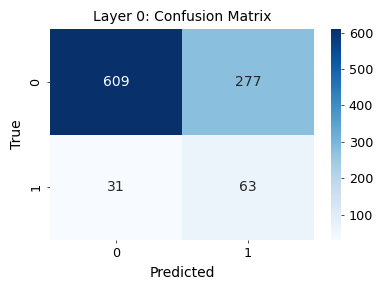


Layer 1:
Best C: 0.100
Train Balanced Accuracy: 0.868
Test Balanced Accuracy: 0.758
Train Weighted F1: 0.880
Test Weighted F1: 0.855
Class distribution:
Class False: 8033 samples
Class True: 785 samples



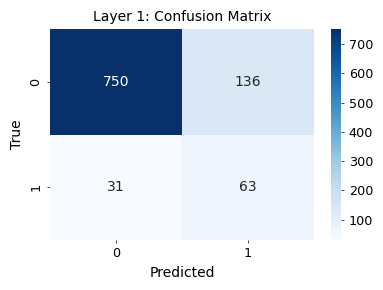


Layer 2:
Best C: 0.003
Train Balanced Accuracy: 0.939
Test Balanced Accuracy: 0.920
Train Weighted F1: 0.936
Test Weighted F1: 0.926
Class distribution:
Class False: 8033 samples
Class True: 785 samples



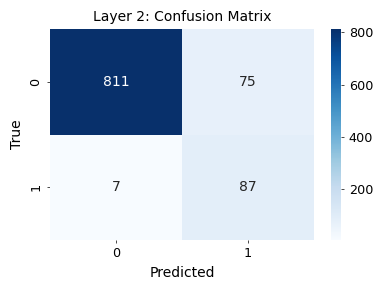


Layer 3:
Best C: 0.001
Train Balanced Accuracy: 0.974
Test Balanced Accuracy: 0.965
Train Weighted F1: 0.964
Test Weighted F1: 0.950
Class distribution:
Class False: 8033 samples
Class True: 785 samples



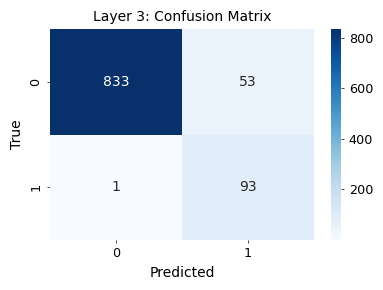

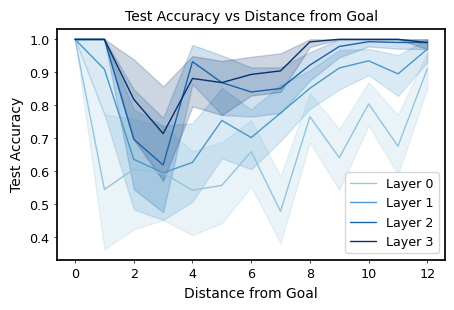

In [31]:
train_indices = []; test_indices = []
for i in range(len(Ys_dict['opt_action']["Y_train"])):
    opt_action = Ys_dict['opt_action']["Y_train"][i]
    state_feature = Ys_dict['state_feature']["Y_train"][i]
    next_state_feature = Ys_dict['next_state_feature']["Y_train"][i]
    train_indices.append(i)
for i in range(len(Ys_dict['opt_action']["Y_test"])):
    opt_action = Ys_dict['opt_action']["Y_test"][i]
    state_feature = Ys_dict['state_feature']["Y_test"][i]
    next_state_feature = Ys_dict['next_state_feature']["Y_test"][i]
    test_indices.append(i)
_Y_train = [Ys_dict['on_lr_path']["Y_train"][i] for i in train_indices]
_Y_test = [Ys_dict['on_lr_path']["Y_test"][i] for i in test_indices]
_X_train = [[X[i] for i in train_indices] for X in X_train] 
_X_test = [[X[i] for i in test_indices] for X in X_test]
pipeline, test_score = fit_and_evaluate_classification(
    _X_train, _Y_train, _X_test, _Y_test)

dist_from_goal = [Ys_dict['dist_from_goal']["Y_test"][i] for i in test_indices]
fig, ax = plt.subplots(figsize=(5,3))
colors = plt.colormaps['Blues'](np.linspace(0.4, 1, len(test_score)))
for l in range(len(test_score)):
    test_acc = test_score[l]
    sns.lineplot(x=dist_from_goal, y=test_acc, ax=ax, label=f'Layer {l}', color=colors[l])
ax.set_xlabel('Distance from Goal')
ax.set_ylabel('Test Accuracy')
ax.set_title('Test Accuracy vs Distance from Goal')
ax.legend()
plt.show()

Layer 0:
Best C: 316.228
Train Balanced Accuracy: 0.736
Test Balanced Accuracy: 0.699
Train Weighted F1: 0.735
Test Weighted F1: 0.697
Class distribution:
Class 1: 367 samples
Class 2: 359 samples



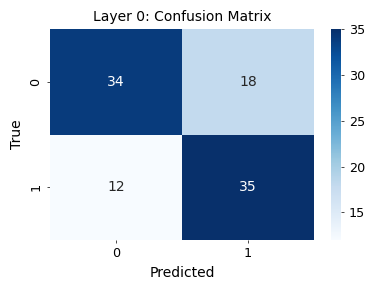


Layer 1:
Best C: 0.316
Train Balanced Accuracy: 0.949
Test Balanced Accuracy: 0.769
Train Weighted F1: 0.949
Test Weighted F1: 0.768
Class distribution:
Class 1: 367 samples
Class 2: 359 samples



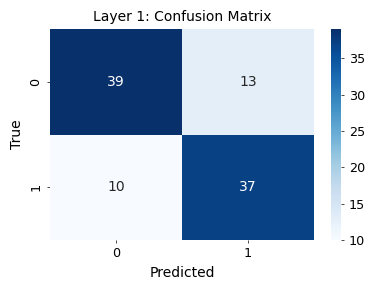


Layer 2:
Best C: 10000.000
Train Balanced Accuracy: 1.000
Test Balanced Accuracy: 0.811
Train Weighted F1: 1.000
Test Weighted F1: 0.808
Class distribution:
Class 1: 367 samples
Class 2: 359 samples



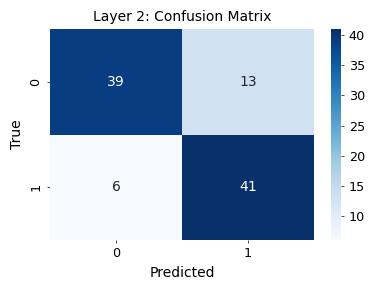


Layer 3:
Best C: 0.032
Train Balanced Accuracy: 0.997
Test Balanced Accuracy: 0.959
Train Weighted F1: 0.997
Test Weighted F1: 0.960
Class distribution:
Class 1: 367 samples
Class 2: 359 samples



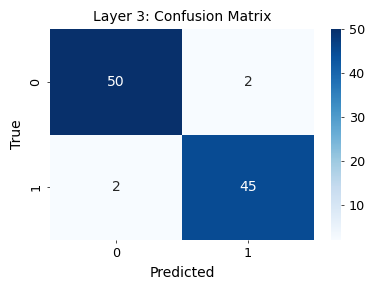

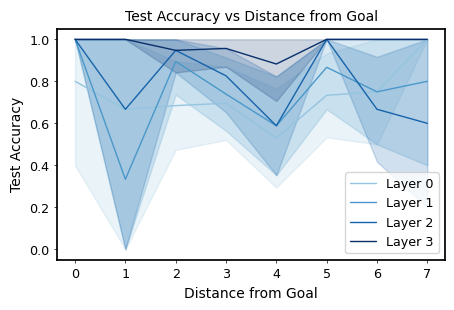

In [32]:
train_indices = []; test_indices = []
for i in range(len(Ys_dict['opt_action']["Y_train"])):
    opt_action = Ys_dict['opt_action']["Y_train"][i]
    state_feature = Ys_dict['state_feature']["Y_train"][i]
    next_state_feature = Ys_dict['next_state_feature']["Y_train"][i]
    if opt_action not in [1, 2]:
        continue
    if np.array_equal(state_feature, next_state_feature):
        continue
    train_indices.append(i)
for i in range(len(Ys_dict['opt_action']["Y_test"])):
    opt_action = Ys_dict['opt_action']["Y_test"][i]
    state_feature = Ys_dict['state_feature']["Y_test"][i]
    next_state_feature = Ys_dict['next_state_feature']["Y_test"][i]
    if opt_action not in [1, 2]:
        continue
    if np.array_equal(state_feature, next_state_feature):
        continue
    test_indices.append(i)
_Y_train = [Ys_dict['opt_action']["Y_train"][i] for i in train_indices]
_Y_test = [Ys_dict['opt_action']["Y_test"][i] for i in test_indices]
_X_train = [[X[i] for i in train_indices] for X in X_train] 
_X_test = [[X[i] for i in test_indices] for X in X_test]
pipeline, test_score = fit_and_evaluate_classification(
    _X_train, _Y_train, _X_test, _Y_test)

dist_from_goal = [Ys_dict['dist_from_goal']["Y_test"][i] for i in test_indices]
fig, ax = plt.subplots(figsize=(5,3))
colors = plt.colormaps['Blues'](np.linspace(0.4, 1, len(test_score)))
for l in range(len(test_score)):
    test_acc = test_score[l]
    sns.lineplot(x=dist_from_goal, y=test_acc, ax=ax, label=f'Layer {l}', color=colors[l])
ax.set_xlabel('Distance from Goal')
ax.set_ylabel('Test Accuracy')
ax.set_title('Test Accuracy vs Distance from Goal')
ax.legend()
plt.show()

Layer 0:
Best C: 0.003
Train Balanced Accuracy: 0.655
Test Balanced Accuracy: 0.637
Train Weighted F1: 0.682
Test Weighted F1: 0.659
Class distribution:
Class False: 6128 samples
Class True: 2690 samples



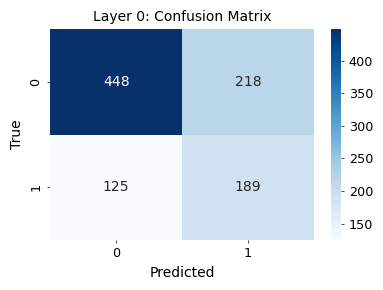


Layer 1:
Best C: 0.100
Train Balanced Accuracy: 0.763
Test Balanced Accuracy: 0.682
Train Weighted F1: 0.774
Test Weighted F1: 0.701
Class distribution:
Class False: 6128 samples
Class True: 2690 samples



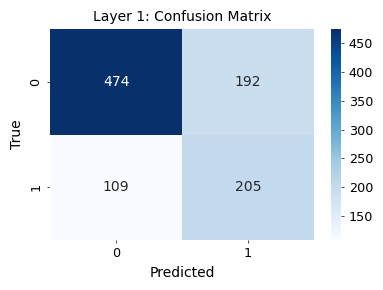


Layer 2:
Best C: 0.100
Train Balanced Accuracy: 0.836
Test Balanced Accuracy: 0.775
Train Weighted F1: 0.843
Test Weighted F1: 0.789
Class distribution:
Class False: 6128 samples
Class True: 2690 samples



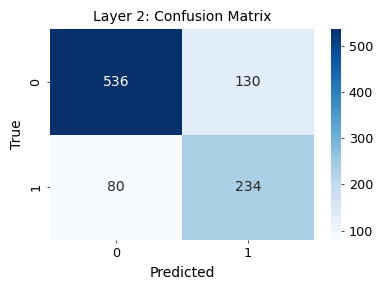


Layer 3:
Best C: 0.316
Train Balanced Accuracy: 0.871
Test Balanced Accuracy: 0.828
Train Weighted F1: 0.877
Test Weighted F1: 0.841
Class distribution:
Class False: 6128 samples
Class True: 2690 samples



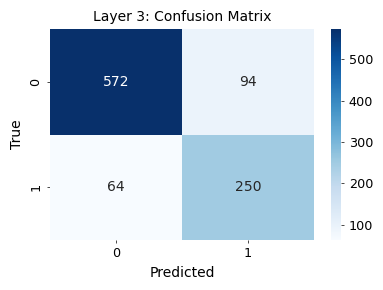

In [15]:
pipeline, test_score = fit_and_evaluate_classification(
    X_train,
    [y <= 6 for y in Ys_dict["dist_from_goal"]["Y_train"]],
    X_test,
    [y <= 6 for y in Ys_dict["dist_from_goal"]["Y_test"]]
    )

Layer 0:
Best C: 0.001
Train Balanced Accuracy: 0.279
Test Balanced Accuracy: 0.227
Train Weighted F1: 0.196
Test Weighted F1: 0.161
Class distribution:
Class 0: 109 samples
Class 1: 165 samples
Class 2: 262 samples
Class 3: 330 samples
Class 4: 439 samples
Class 5: 574 samples
Class 6: 811 samples
Class 7: 829 samples
Class 8: 1094 samples
Class 9: 1058 samples
Class 10: 1268 samples
Class 11: 930 samples
Class 12: 949 samples



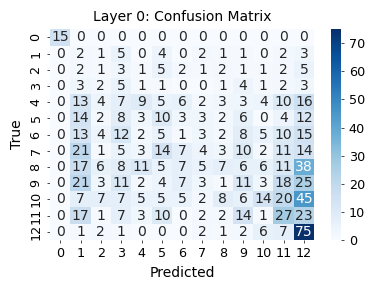


Layer 1:
Best C: 0.100
Train Balanced Accuracy: 0.533
Test Balanced Accuracy: 0.363
Train Weighted F1: 0.422
Test Weighted F1: 0.286
Class distribution:
Class 0: 109 samples
Class 1: 165 samples
Class 2: 262 samples
Class 3: 330 samples
Class 4: 439 samples
Class 5: 574 samples
Class 6: 811 samples
Class 7: 829 samples
Class 8: 1094 samples
Class 9: 1058 samples
Class 10: 1268 samples
Class 11: 930 samples
Class 12: 949 samples



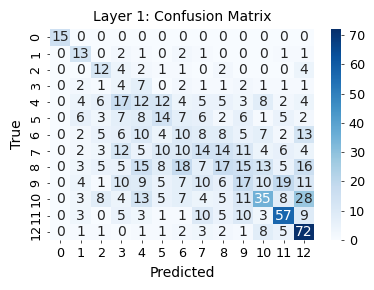


Layer 2:
Best C: 0.100
Train Balanced Accuracy: 0.643
Test Balanced Accuracy: 0.479
Train Weighted F1: 0.543
Test Weighted F1: 0.408
Class distribution:
Class 0: 109 samples
Class 1: 165 samples
Class 2: 262 samples
Class 3: 330 samples
Class 4: 439 samples
Class 5: 574 samples
Class 6: 811 samples
Class 7: 829 samples
Class 8: 1094 samples
Class 9: 1058 samples
Class 10: 1268 samples
Class 11: 930 samples
Class 12: 949 samples



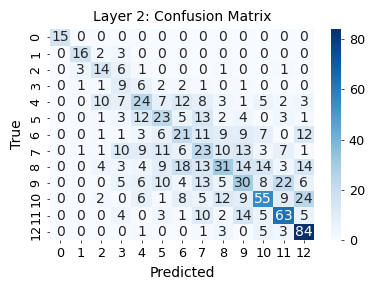


Layer 3:
Best C: 0.100
Train Balanced Accuracy: 0.671
Test Balanced Accuracy: 0.475
Train Weighted F1: 0.572
Test Weighted F1: 0.406
Class distribution:
Class 0: 109 samples
Class 1: 165 samples
Class 2: 262 samples
Class 3: 330 samples
Class 4: 439 samples
Class 5: 574 samples
Class 6: 811 samples
Class 7: 829 samples
Class 8: 1094 samples
Class 9: 1058 samples
Class 10: 1268 samples
Class 11: 930 samples
Class 12: 949 samples



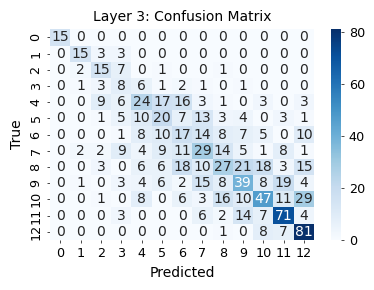

In [16]:
pipeline, test_score = fit_and_evaluate_classification(
    X_train,
    Ys_dict["dist_from_goal"]["Y_train"],
    X_test,
    Ys_dict["dist_from_goal"]["Y_test"]
    )